# Simulating InSAR Noise Data

## 0. Importing Data and Setting Up Clean Background

We need to start by having a "clean" background to view our noise over. This can just be a 0 of the same size as our noise matrices. When training, this needs to be an actual image. Preferably of as close to 'clean' InSAR data as possible.

We are setting our default size to be 1500x1500 as that's what the example paper had.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

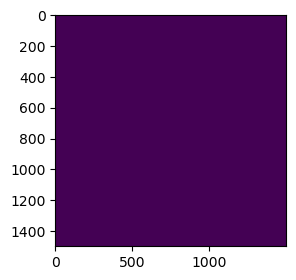

In [15]:
# Define our clean image as an empty array
size = (1500, 1500)
clean = np.zeros(size)

plt.figure(figsize=(3,3))
plt.imshow(clean)

## 1. Simulating Random Noise as a Gaussian Distribution 

The easiest type of noise we can add is the random noise, as we are simulating this as a Gaussian (normal) distribution with a $\mu = 0$ and $\sigma = 0.56$. This is a simple function built into numpy.

In [16]:
def generate_random_noise(size, std=0.56):
    # Return a matrix with a normal distribution with mean at 0 and passed in size/std
    return np.random.normal(loc=0.0, scale=std, size=size)

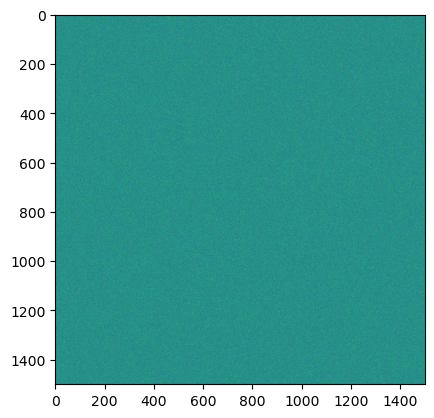

In [17]:
test_gaus = generate_random_noise(size)
plt.imshow(test_gaus)

## 2. Simulating Tropospheric Noise

The second type of noise we want to add is tropospheric noise. 

This noise is slightly different than our Gaussian noise as it's not "White Noise." That is to say, each pixel is not independent in picking from the distribution. 

Rather, the frequency across the x and y axes determines the noise level at a specific pixel. In our case, the distirbution follows the "Power Law" $P(k) \propto k^{-\beta}$, where $k$ is the spatial frequency, and $\beta$ is a constant controlling how quickly power decays with frequency. From the given paper we will use $\beta = 1.82$.

However, because we are dealing discrete pixels (not a continuous distribution) we need to use np.fft.fftfreq() to generate a discrete frequency array for our pixels. We need to do this for both the x and y axis. After this we can calculate the radial frequency (circular frequency from the center) by calculating the magnitude as $k = \sqrt{k_{x}^{2} + k_{y}^{2}}$

In [22]:
def generate_tropospheric_noise(size, beta=1.82, scale=1.0):
    # Create a frequency domain based on a standard normal distribution
    noise = np.fft.fft2(np.random.randn(*size)) 

    # Create our discrte frequency distributions over x and y axes
    ky = np.fft.fftfreq(size[0])
    kx = np.fft.fftfreq(size[1])

    # Mesh them together get the specific axes
    kx, ky = np.meshgrid(kx, ky)

    # Compute the radial spatial frequency (frequency from the center)
    k = np.sqrt(kx**2 + ky**2)
    k[0, 0] = 1e-7

    # Calculate the power law
    power = k ** (-beta)

    # Use inverse fourier transform to calculate it back in spatial domain
    frac_noise = np.fft.ifft2(noise * power).real

    # Normalize it
    frac_noise = (frac_noise - frac_noise.mean()) / frac_noise.std()
    return frac_noise * scale

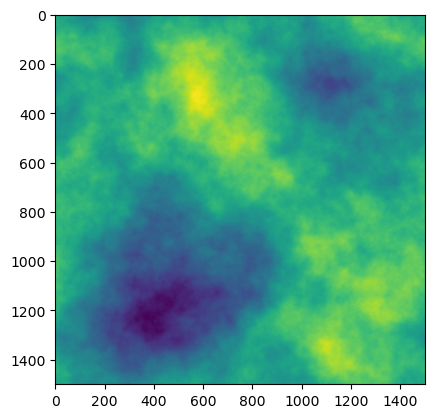

In [23]:
test_trop = generate_tropospheric_noise(size)
plt.imshow(test_trop)

# 3. Simulating Subsidence Background

The final piece we need to be simulating, is the background of the image itself. Using the synthetic subsidence "Zoback model" outlined in the paper we mathematically calculate what we are aiming to recover with our CNN models.

The formulas given were for the radial displacement and the vertical displacement:
$u_{r}(r, 0) = -\frac{1}{\pi c_m (1 - v)} \frac{r}{(r^2 + D^2)^\frac{3}{2}} \Delta P_p V$


$u_{z}(z, 0) = -\frac{1}{\pi c_m (1 - v)} \frac{D}{(r^2 + D^2)^\frac{3}{2}} \Delta P_p V$

All these parameters are properly defined in the given powerpoint and outlined in the referenced paper. We need to simply use the vertical formula as we are only simulating 1 satellite for now.

In [ ]:
def generate_vertical_displacement(size, D=50, delta_P=1.0, nu=0.25, cm=1.0, v=1.0):
    # Get the index arrays
    y, x = np.indices(size)

    # Calculate the center
    cx, cy = shape[1] // 2, shape[0] // 2

    
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    factor = -1 / (np.pi * cm * (1 - nu)) * delta_P * V
    